## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [167]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [169]:
data['date'] = pd.to_datetime(data['date'])
data.groupby(by='group')['date'].agg(['min','max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [170]:
data.groupby(by='group').agg({'user_id':'count','purchase':'sum','price':'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [171]:
users_a = set(data[data['group']=='A']['user_id'])
users_b = set(data[data['group']=='B']['user_id'])
user_intersection = users_a.intersection(users_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [172]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:


| group | count_visits | count_purchases | sum_price |
| --- | --- | --- | --- |
| A | ? | ? | ? |
| B | ? | ? | ? |
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

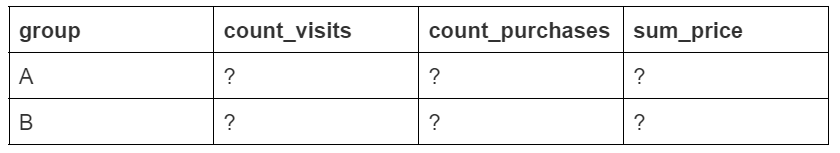

In [173]:
grouped_updated_data = updated_data.groupby(by='group').agg({'user_id':'count','purchase':'sum','price':'sum'})
grouped_updated_data.rename(columns={'user_id':'count_visits','purchase':'count_purchases','price':'sum_price'}, inplace=True)
grouped_updated_data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

<u>Промежуточные выводы</u>: разница в количестве посещений обоих вариантов страниц составляет около 0.05%. Такой разницей можно пренебречь. Выборки сбалансированны.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [174]:
grouped_updated_data['conversion'] = grouped_updated_data.apply(lambda row: round(row['count_purchases'] / row['count_visits'] * 100, 2), axis=1)
grouped_updated_data['mean_check'] = grouped_updated_data.apply(lambda row: round(row['sum_price'] / row['count_purchases']), axis=1)
grouped_updated_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076
B,145381,17290,1533010000,11.89,88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

<u>Промежуточные выводы</u>: конверсия оказалась выше в контрольной группе А, но незначительно, на 0.14%. Но при этом средний чек оказался выше в тестовой группе B. Визуально видно преимущество тестовой группы B, но это требует подтверждения.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [175]:
purchasing_power_piv = pd.pivot_table(
    updated_data[updated_data['purchase']==1],
    values='user_id',
    index='group',
    columns='price',
    aggfunc='count'
)
purchasing_power_piv

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Pависимость количества продаж от группы и цены тура')

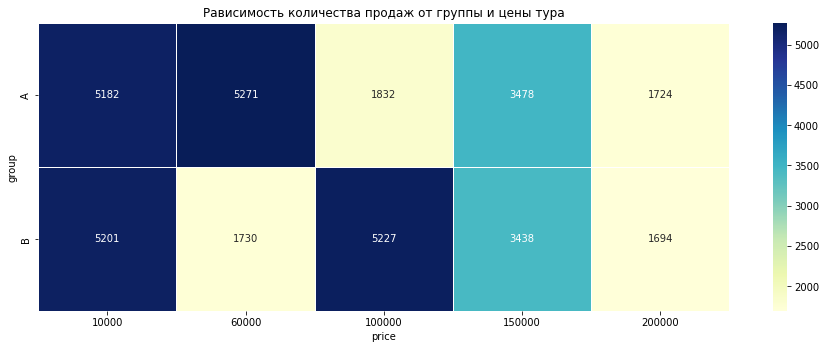

In [176]:
fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
sns.heatmap(purchasing_power_piv, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_title('Pависимость количества продаж от группы и цены тура')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

<u>Промежуточные выводы</u>: в данных туркомпании есть 5 видов туров, в разные места и с разной стоимостью. В тестовой и контрольной группах распределение по турам примерно одинаковое, за исключением двух туров:
* Турция, 60000р – ощутимо больше куплено туров в группе A
* Таиланд, 100000р – ощутимо больше куплено туров в группе B

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [177]:
updated_data_daily = updated_data.groupby(by=['date','group']).agg({'user_id':'count','purchase':'sum','price':'sum'})
updated_data_daily.rename(columns={'user_id':'count_visits','purchase':'count_purchases','price':'sum_price'}, inplace=True)
updated_data_daily['conversion'] = updated_data_daily['count_purchases'] / updated_data_daily['count_visits'] * 100
updated_data_daily['average_check'] = updated_data_daily['sum_price'] / updated_data_daily['count_purchases']
updated_data_daily.head()

count_visits  count_purchases  sum_price  conversion  \
date       group                                                         
2021-01-02 A              2854              359   29410000   12.578837   
           B              2861              345   29660000   12.058721   
2021-01-03 A              6596              748   62000000   11.340206   
           B              6619              754   65960000   11.391449   
2021-01-04 A              6566              799   64250000   12.168748   

                  average_check  
date       group                 
2021-01-02 A       81922.005571  
           B       85971.014493  
2021-01-03 A       82887.700535  
           B       87480.106101  
2021-01-04 A       80413.016270

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [178]:
updated_data_daily['count_visits_cum'] = updated_data_daily.groupby(by='group')['count_visits'].cumsum()
updated_data_daily['count_purchases_cum'] = updated_data_daily.groupby(by='group')['count_purchases'].cumsum()
updated_data_daily['sum_price_cum'] = updated_data_daily.groupby(by='group')['sum_price'].cumsum()
updated_data_daily['conversion_cum'] = updated_data_daily['count_purchases_cum'] / updated_data_daily['count_visits_cum'] * 100
updated_data_daily['sum_price_cum'] = updated_data_daily['sum_price_cum'] / updated_data_daily['count_purchases_cum']
updated_data_daily.head()

count_visits  count_purchases  sum_price  conversion  \
date       group                                                         
2021-01-02 A              2854              359   29410000   12.578837   
           B              2861              345   29660000   12.058721   
2021-01-03 A              6596              748   62000000   11.340206   
           B              6619              754   65960000   11.391449   
2021-01-04 A              6566              799   64250000   12.168748   

                  average_check  count_visits_cum  count_purchases_cum  \
date       group                                                         
2021-01-02 A       81922.005571              2854                  359   
           B       85971.014493              2861                  345   
2021-01-03 A       82887.700535              9450                 1107   
           B       87480.106101              9480                 1099   
2021-01-04 A       80413.016270             16016                 1906   

                  sum_price_cum  conversion_cum  
date       group                                 
2021-01-02 A       81922.005571       12.578837  
           B       85971.014493       12.058721  
2021-01-03 A       82574.525745       11.714286  
           B       87006.369427       11.592827  
2021-01-04 A       81668.415530       11.900599

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

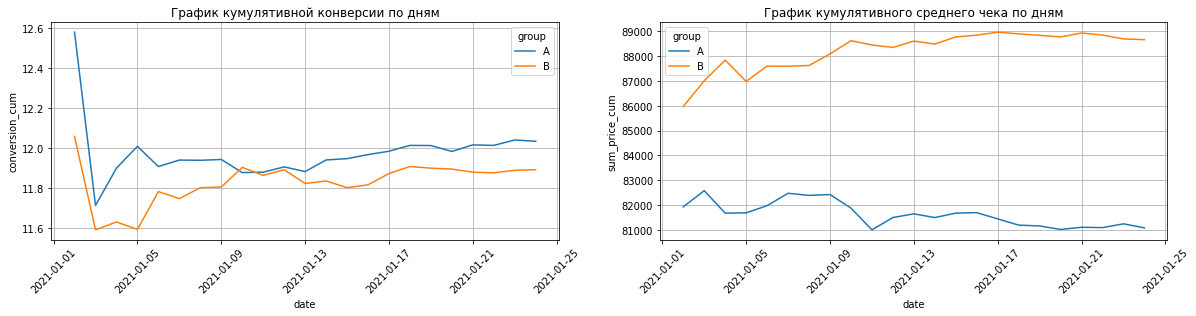

In [179]:
# создаём фигуру размером 20x4
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 4))
# строим lineplot для кумулятивной конверсии и кумулятивного среднего чека во времени в каждой группе
sns.lineplot(data=updated_data_daily, x='date', y='conversion_cum', hue='group', ax=ax1)
sns.lineplot(data=updated_data_daily, x='date', y='sum_price_cum', hue='group', ax=ax2)
# задаём подпись к графику
ax1.set_title('График кумулятивной конверсии по дням')
ax2.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax1.xaxis.set_tick_params(rotation = 45)
ax2.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax1.grid(True)
ax2.grid(True)

<u>Промежуточные выводы</u>: примерно до 2021-01-13 оба показателя были нестабильны, но далее оба показателя выходят на стабильную прямую. На основании этих графиков делаем вывод, что длительность эксперимента была достаточной для формирования правильных выводов по полученным данным.

Также уже на графиках можно обратить внимание, что конверсия выше в группе А, но ненамного. При этом средний чек ощутимо выше в группе B, что может быть сигналом к принятию изменений.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [180]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_updated_data['count_purchases'], #число "успехов"
    nobs=grouped_updated_data['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. H0: {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

<u>Промежуточные выводы</u>: даже если бы мы приняли $\alpha$=0.1, то статистической разницы между конверсиями в группах A и B не было бы. Вывод – считаем конверсии равными.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [181]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    """Вычисление доверительного интервала для пропорций

    Args:
        n (int): размер выборки
        x_p (float): выборочная пропорция
        gamma (float, optional): уровень надёжности. Defaults to 0.95

    Returns:
        float, float: кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой
    """
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [182]:
# разделим данные по группам
a_data = updated_data[updated_data['group']=='A']
b_data = updated_data[updated_data['group']=='B']
a_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0


In [183]:
conf_interval_a = proportions_conf_interval(
    n = a_data['user_id'].count(), # размер выборки
    x_p = a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
    n = b_data['user_id'].count(), # размер выборки
    x_p = b_data['purchase'].mean() # выборочная пропорция
)
print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [184]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """Вычисление границ доверительного интервала разницы конверсий

    Args:
        n (list): список из размеров выборки для групп А и B соответственно
        xp (list): список из выборочных пропорций для групп А и B соответственно
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        tupple: кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % 
        и округлённых до второго знака после запятой
    """
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

Построим интересующий нас доверительный интервал

In [185]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

<u>Промежуточные выводы</u>: построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

То есть тест на построение доверительного интервала пропорций подтвердил результаты Z-теста: статистической разницы между конверсиями в группах A и B нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [186]:
updated_data_daily.reset_index(inplace=True)
a_daily_data = updated_data_daily[updated_data_daily['group']=='A']
b_daily_data = updated_data_daily[updated_data_daily['group']=='B']

In [187]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(a_daily_data['average_check'])
shapiro_result_b = shapiro(b_daily_data['average_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [188]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=a_daily_data['average_check'],
    b=b_daily_data['average_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

<u>Промежуточные выводы</u>: полученный уровень значимости стремится к нулю, значит мы можем отвергнуть нулевую гипотезу и принять альтернативную – между средними чеками есть статистическая разница. Причём на графиках мы видели, что в группе A средний чек ниже, чем в группе B, поэтому именно такую альтернативную гипотезу мы и рассматривали.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [189]:
def calculate_confidence_interval_t(n, x_mean, x_std, gamma=0.95):
    """Функция для расчёта доверительного интервала для истинного среднего при неизвестном стандартном отклонении

    Args:
        n (int): размер выборки
        x_mean (float): выборочное среднее
        x_std (float): выборочное стандартное отклонение
        gamma (float): уровень надёжности

    Returns:
        tuple: кортеж с округлёнными границами расчитанного интервала
    """
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала

In [190]:
n_a = a_daily_data['average_check'].count()
x_mean_a = a_daily_data['average_check'].mean()
x_std_a = a_daily_data['average_check'].std()

n_b = b_daily_data['average_check'].count()
x_mean_b = b_daily_data['average_check'].mean()
x_std_b = b_daily_data['average_check'].std()


print(f"Доверительноый интервал для истинного среднего чека в группе A: {calculate_confidence_interval_t(n_a, x_mean_a, x_std_a)}")
print(f"Доверительноый интервал для истинного среднего чека в группе B: {calculate_confidence_interval_t(n_b, x_mean_b, x_std_b)}")

Доверительноый интервал для истинного среднего чека в группе A: (79630, 82308)
Доверительноый интервал для истинного среднего чека в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

<u>Промежуточные выводы</u>: как мы видели на графике, средний чек в группе B ощутимо выше этого же показателя в группе A. 

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

<u>Итоговый вывод</u>: в рамках A/B тестирования рассматривается два варианта посадочной страницы официального сайта компании. Необходимо проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный. При этом в A/B тестировании принмиало участие 5 туров с различной стоимостью и привлекательностью для клиентов.

Наблюдения:
* У двух туров привлекательная способность оказалось разной в разных группах. В остальных трёх турах соотношение покупок между группами примерно одинаковое.
* Конверсия в двух группах оказалась статистически равной, но при этом средний чек выше в группе B. Причём это видно как по графикам, так и под построенным доверительным интервалам. Оба интервала не пересекаются, в группе B доверительный интервал выше.

По итогу можно сделать вывод, что вариант посадочной страницы группы B никак не влияет на конверсию, но при этом ощутимо повысился средний чек. Можно смело внедрять новый вариант страницы для всех клиентов.
